<a href="https://colab.research.google.com/github/TatsukiIshijima/Colab_Notebooks/blob/main/TensorFlowTTS_tacotron2_with_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TensorFlowTTS の tacotron2 を TFLite 形式モデルに変換する

TensorFlowTTS リポジトリの説明や notebooks を参考に tacotron2 の TFLite 形式のモデルに変換をやってみる  
TensorFlowTTS のリポジトリにある notebooks に変換のスクリプト等を実行している .ipynb があるが、バージョン違いにより動かないことや書き方の違いがあったので以下を参考にした  
https://colab.research.google.com/drive/1HudLLpT9CQdh2k04c06bHUwLubhGTWxA?usp=sharing

#### TensorFlowTTS をソースからインストールするためにリポジトリをクローン

In [ ]:
!git clone https://github.com/TensorSpeech/TensorFlowTTS.git

Cloning into 'TensorFlowTTS'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 10230 (delta 5), reused 8 (delta 1), pack-reused 10207
Receiving objects: 100% (10230/10230), 110.33 MiB | 31.40 MiB/s, done.
Resolving deltas: 100% (4903/4903), done.


ディレクトリの移動

In [ ]:
%cd TensorFlowTTS

/content/TensorFlowTTS


#### TensorFlowTTS をインストール

In [ ]:
pip install .

Processing /content/TensorFlowTTS
     |████████████████████████████████| 320.4MB 51kB/s 
     |████████████████████████████████| 706kB 54.5MB/s 
     |████████████████████████████████| 245kB 33.4MB/s 
     |████████████████████████████████| 225kB 56.0MB/s 
     |████████████████████████████████| 3.5MB 43.6MB/s 
     |████████████████████████████████| 1.3MB 55.4MB/s 
     |████████████████████████████████| 1.7MB 55.6MB/s 
     |████████████████████████████████| 3.1MB 61.8MB/s 
  Cloning https://github.com/repodiac/german_transliterate.git to /tmp/pip-install-r6xsxzjq/german-transliterate
  Running command git clone -q https://github.com/repodiac/german_transliterate.git /tmp/pip-install-r6xsxzjq/german-transliterate
     |████████████████████████████████| 460kB 51.6MB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
     |████████████████████████████████| 184kB 47.3MB/s 
     |████████████████████████████████| 102kB 15.1

In [ ]:
!pip install tf-nightly

     |████████████████████████████████| 408.1MB 37kB/s 
     |████████████████████████████████| 5.9MB 30.4MB/s 
     |████████████████████████████████| 4.0MB 43.8MB/s 
     |████████████████████████████████| 14.8MB 108kB/s 
     |████████████████████████████████| 471kB 53.9MB/s 
     |████████████████████████████████| 4.0MB 41.1MB/s 
     |████████████████████████████████| 3.8MB 48.3MB/s 
ERROR: umap-learn 0.5.0 has requirement numba>=0.49, but you'll have numba 0.48.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
ERROR: tensorflow-gpu 2.3.1 has requirement g

#### Google Drive のマウント

MelGAN や Tacotron2 の学習モデルをダウンロードし自分の Google Drive へアップロードした。そして自分の Google Drive をマウントし、学習モデルをそこから読み込めるようにした

In [ ]:
from google.colab import drive
# Google Drive のマウント
drive.mount('/content/drive')

Mounted at /content/drive


#### 必要なライブラリのインポート

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import yaml
import tensorflow as tf

from tensorflow_tts.processor import LJSpeechProcessor
from tensorflow_tts.processor.ljspeech import LJSPEECH_SYMBOLS

from tensorflow_tts.configs import Tacotron2Config
from tensorflow_tts.configs import MelGANGeneratorConfig

from tensorflow_tts.models import TFTacotron2
from tensorflow_tts.models import TFMelGANGenerator

from IPython.display import Audio
print(tf.__version__)

2.5.0-dev20210212


#### 学習済みモデルのパラメータ等の読み込み

学習済みモデル（.h5）は TensorFlowTTS/examples/melgan の Pretrained Models and Audio samples からダウンロードした

In [ ]:
# initialize melgan model
with open('examples/melgan/conf/melgan.v1.yaml') as f:
    melgan_config = yaml.load(f, Loader=yaml.Loader)
melgan_config = MelGANGeneratorConfig(**melgan_config["melgan_generator_params"])
melgan = TFMelGANGenerator(config=melgan_config, name='melgan_generator')
melgan._build()
melgan.load_weights("/content/drive/My Drive/Colab Notebooks/TensorFlowTTS/melgan.v1/checkpoints/generator-1500000.h5")

学習済みモデル（.h5）は TensorFlowTTS/examples/tacotron2 の Pretrained Models and Audio samples からダウンロードした

In [ ]:
# initialize Tacotron2 model.
with open('examples/tacotron2/conf/tacotron2.v1.yaml') as f:
    config = yaml.load(f, Loader=yaml.Loader)
config = Tacotron2Config(**config["tacotron2_params"])
# 最新のTensorFlowTTS の TFTacotron2 には training 引数がなかったため削除
tacotron2 = TFTacotron2(config=config, name="tacotron2v2", enable_tflite_convertible=True)

# Newly added :
tacotron2.setup_window(win_front=6, win_back=6)
tacotron2.setup_maximum_iterations(3000)

tacotron2._build()
tacotron2.load_weights("/content/drive/My Drive/Colab Notebooks/TensorFlowTTS/tacotron2.v1/checkpoints/model-120000.h5")
tacotron2.summary()

Model: "tacotron2v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (TFTacotronEncoder)  multiple                  8218624   
_________________________________________________________________
decoder_cell (TFTacotronDeco multiple                  18246402  
_________________________________________________________________
post_net (TFTacotronPostnet) multiple                  5460480   
_________________________________________________________________
residual_projection (Dense)  multiple                  41040     
Total params: 31,966,546
Trainable params: 31,956,306
Non-trainable params: 10,240
_________________________________________________________________


#### TFLite 形式へ変換

In [ ]:
# Concrete Function
tacotron2_concrete_function = tacotron2.inference_tflite.get_concrete_function()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
converter = tf.lite.TFLiteConverter.from_concrete_functions(
    [tacotron2_concrete_function]
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

変換したモデルのダウンロード。（自分のドライブへ）

In [ ]:
# Save the TF Lite model.
with open('/content/drive/My Drive/Colab Notebooks/TensorFlowTTS/tacotron2.v1/tacotron2.tflite', 'wb') as f:
  f.write(tflite_model)

print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0) )

Model size is 32.739685 MBs.


## TFLite 形式モデルに変換した tacotron2 を使ってみる

In [ ]:
import numpy as np
import tensorflow as tf

# TFLite model の読み込み
interpreter = tf.lite.Interpreter(model_path='/content/drive/My Drive/Colab Notebooks/TensorFlowTTS/tacotron2.v1/tacotron2.tflite')
interpreter.allocate_tensors()

# 入力と出力のテンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print('input_details : ', input_details)
print('output_details : ', output_details)

# 入力データの準備
def prepare_input(input_ids):
    return (tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
            tf.convert_to_tensor([len(input_ids)], tf.int32),
            tf.convert_to_tensor([0], dtype=tf.int32))
    
# 適当な入力データによるモデルの動作確認
def infer(input_text):
    processor = LJSpeechProcessor(None, symbols=LJSPEECH_SYMBOLS)
    input_ids = processor.text_to_sequence(input_text.lower())
    interpreter.resize_tensor_input(input_details[0]['index'], [1, len(input_ids)])
    interpreter.allocate_tensors()
    input_data = prepare_input(input_ids)
    for i, detail in enumerate(input_details):
        print(detail)
        input_shape = detail['shape']
        interpreter.set_tensor(detail['index'], input_data[i])
    
    interpreter.invoke()

    return (interpreter.get_tensor(output_details[0]['index']),
            interpreter.get_tensor(output_details[1]['index']))

input_details :  [{'name': 'input_ids', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([ 1, -1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'input_lengths', 'index': 1, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'speaker_ids', 'index': 2, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_pa

#### tactron2 と melGAN で text-to-speech を試す

tflite形式の tacotron2 でテキストからメルスペクトグラムに変化し、tflite 形式のmelGAN でメルスペクトグラムから音声へ変換する

In [ ]:
input_text = "Recent research at Harvard has shown meditating for as little as 8 weeks, can actually increase the grey matter in the parts of the brain responsible for emotional regulation, and learning."

decoder_output_tffile, mel_output_tflite = infer(input_text)
audio_before_tflite = melgan(decoder_output_tffile)[0, :, 0]
audio_after_tflite = melgan(mel_output_tflite)[0, :, 0]

{'name': 'input_ids', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([ 1, -1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'input_lengths', 'index': 1, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'speaker_ids', 'index': 2, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


#### tacotron2 でテキストから変換されたメルスペクトグラムを画像で確認

In [ ]:
def visualize_mel_spectrogram(mels):
    mels = tf.reshape(mels, [-1, 80]).numpy()
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(311)
    ax1.set_title(f'Predicted Mel-after-Spectrogram')
    im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
    plt.show()
    plt.close()

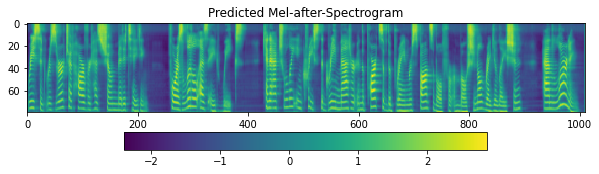

In [ ]:
visualize_mel_spectrogram(decoder_output_tffile)

#### melGAN で変換された音声を再生する

In [ ]:
Audio(data=audio_before_tflite, rate=22050)

In [ ]:
Audio(data=audio_after_tflite, rate=22050)

#### 別の入力データ（テキスト）で試してみる

In [ ]:
input_text = "I love TensorFlow Lite converted Tacotron 2."

decoder_output_tflite, mel_output_tflite = infer(input_text)
audio_before_tflite = melgan(decoder_output_tflite)[0, :, 0]
audio_after_tflite = melgan(mel_output_tflite)[0, :, 0]

{'name': 'input_ids', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([ 1, -1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'input_lengths', 'index': 1, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'speaker_ids', 'index': 2, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


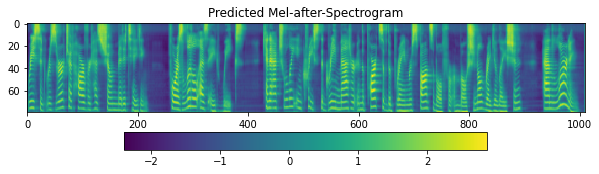

In [ ]:
visualize_mel_spectrogram(decoder_output_tffile)

In [ ]:
Audio(data=audio_before_tflite, rate=22050)

In [ ]:
Audio(data=audio_after_tflite, rate=22050)